In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image
from datetime import datetime
import PIL.ExifTags
from tqdm import tqdm

import dateutil.parser
import os
import re

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, MaxNLocator)

from pyphasechip import pyphasechip_logic as pypc
from typing import Tuple

## Variables

In [2]:
# reagent 1 name
name_sol1 = "BSA"
# reagent 1 starting contentration
initial_conc_sol1 = 266
# unit
unit_sol1 = "µM"


# reagent 2 name
name_sol2 = "PEG"
# reagent 2 starting concentration
initial_conc_sol2 = 10
# unit
unit_sol2 = "%"


# mixing ratio of the concentrations 0
# [1:X]
initial_ratio = 7


# Number of different concentrations used
number_of_diff_conc = 4

# Number of wells
n_wells = 3

###### delete hoe and iph, use this instead
# total amount of images
total_n_images = 528
n_timepoints = int(total_n_images / (number_of_diff_conc * n_wells)) 

# percental difference of img mean to all previous imgages. 
# value is similar to a sensivity-value
percental_threshold = 200 #55


# measured diameter of chamber to calculate radii for circle detection -> min and max [px]
# around +-30 of the real value, best measured with something like imageJ/Fiji
diameter = 238 
minRadiusChamber = int((diameter/2)*0.7)
maxRadiusChamber = int((diameter/2)*1.3)


# height of chamber [µm]
chamber_height = 60

# folder where images are stored
# best is to use only paths without any whitespace
image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\20220601_BSA_PEG_FC40_subset"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\Testimages2+"

# datatype of the images
extension = ".jpg"

# TODO: use a .yml file for storing these variables

In [ ]:
#THIS IS FOR CELLOBSERVER/ZEISS IMAGES ONLY

def get_sorted_file_list(image_folder: str) -> list:
    files, times, concs, wells = [], [], [], []
    
    for file in os.listdir(image_folder):
        # 1. More robust, faster, but more specific
        c, w, _, t = re.search("c(\d+)_w(\d+)_s(\d+)t(\d+)", file).groups()

        # 2. Other way
        #c, w, _, t, *params = re.findall('[0-9]+', file)
        
        # Generate lists
        times.append(int(t))
        concs.append(int(c))
        wells.append(int(w))
        files.append(file)
        
    return [x for _, _, _, x in sorted(zip(concs, times, wells, files))]
    
get_sorted_file_list(image_folder)

## Programm

In [3]:
# Create all the necessary dicts and lists
image_list, image_names, data_well, well, concentration, time_resolution = pypc.create()

# Load images & convert to grayscale
print("Write images into list")
pypc.images_to_list(image_list, image_names, image_folder, extension)
print("Save them into a dictionary")
pypc.images_to_dict(n_timepoints, number_of_diff_conc, n_wells, image_list, image_names, time_resolution, concentration, well, data_well)

# Two possibilities:
# use script if you did a pipetting series
starting_concentrations = pypc.starting_concentration(initial_conc_sol1, initial_conc_sol2, initial_ratio)
# or
# write list

print("Analyse data...")
well_nr = 0
for conc_nr in range(number_of_diff_conc): # for n_rows_per_conc in range(2):
    
    for n_wells_per_row in range(n_wells):

        # Initialise variables, arrays and lists
        well_data = np.zeros(shape=(2, 3))
        threshed_img = np.zeros(shape=time_resolution[0][0][0]['gray'].shape, dtype="uint8")
        areas = np.zeros(shape=(1, 2))
        droplet_arr = np.zeros(shape=(2,4))
        mean_list = []
        llps_status = False
        n_0 = 0
        multiple_droplets = None
        multiple_droplets_count = 0

        print("conc:", conc_nr, "well:", well_nr)
        for time_idx in tqdm(range(n_timepoints)): #n_timepoints
            if llps_status is False:
                #print("---", "C:", conc_nr, "W:", well_nr, " T:", time_idx, "---")

                image = time_resolution[time_idx][conc_nr][well_nr]['gray'].copy()

                x, y, r, droplet_data, droplet_found, multiple_droplets_count, masked_img, grad2, well_data = pypc.droplet_detection(image, well_data, diameter, llps_status,
                                                                                                                                     multiple_droplets_count, droplet_arr, time_idx, conc_nr, well_nr)

                time_resolution[time_idx][conc_nr][well_nr]['img'] = masked_img
                time_resolution[time_idx][conc_nr][well_nr]['grad2'] = grad2
                time_resolution[time_idx][conc_nr][well_nr]['manipulated img'] = grad2 # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['droplet data'] = droplet_arr.copy()
                time_resolution[time_idx][conc_nr][well_nr]['x'] = x # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['y'] = y # needed for display
                time_resolution[time_idx][conc_nr][well_nr]['r'] = well_data[0, 2] # needed for display
                time_resolution[0][conc_nr][well_nr]['multiple droplets'] = multiple_droplets_count

                # save first area
                if time_idx == 0:
                    areas[0, 0] = droplet_arr[0, 3]

                llps_status, areas, mean_list, droplet_arr, squi, cro_squi, n_0 = pypc.detect_LLPS(percental_threshold, droplet_arr, llps_status, image, time_idx, areas, mean_list, droplet_found, n_0)
                                                                                                                                                # masked_img
                # if noise is too high, ignore droplet
                # later: change "multiplet droplets" to "ignore well"
                if n_0 > 400:
                    multiple_droplets = True
                    time_resolution[0][conc_nr][well_nr]['multiple droplets'] = multiple_droplets


                time_resolution[0][conc_nr][well_nr]['areas'] = areas
                time_resolution[0][conc_nr][well_nr]['mean list'] = mean_list
                time_resolution[time_idx][conc_nr][well_nr]['squ'] = squi
                time_resolution[time_idx][conc_nr][well_nr]['cro squ'] = cro_squi

                time_resolution[time_idx][conc_nr][well_nr]['droplet array'] = droplet_arr


                if llps_status is True:
                    print("LLPS status: ", llps_status, ", @", "c:", conc_nr, "w:", well_nr, "t:", time_idx)
                    # save img time where llps was found
                    time_resolution[0][conc_nr][well_nr]['time idx'] = time_idx
                    # save name of image where LLPS was detected
                    time_resolution[0][conc_nr][well_nr]['LLPS name'] = time_resolution[time_idx][conc_nr][well_nr]['name']
                    # calculate the critical concentration
                    llps_conc = pypc.ccrit_calculation(starting_concentrations, areas, conc_nr)
                    time_resolution[0][conc_nr][well_nr]['LLPS conc'] = llps_conc

        well_nr += 1
    well_nr = 0

# saves the image names where LLPS was detected and the calculated concentrations to a csv file
# .csv gets safed in the image folder
#pypc.save_results_to_csv(time_resolution, image_folder, number_of_diff_conc, n_wells, hours_of_experiment,
#                       images_per_hour, name_sol1, name_sol2, unit_sol1, unit_sol2)

Write images into list


100%|████████████████████████████████████████████████████████████████████████████████| 528/528 [00:05<00:00, 92.42it/s]


Save them into a dictionary


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

Analyse data...
conc: 0 well: 0
multiple_droplets: n = 51
status: 0,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 401,314,103
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:38,  1.11it/s]

multiple_droplets: n = 74
status: 0,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,310,109
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:38,  1.09it/s]

multiple_droplets: n = 22
status: 0,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,310,106
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:36,  1.11it/s]

multiple_droplets: n = 42
status: 0,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,310,106
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:35,  1.12it/s]

multiple_droplets: n = 157
status: 0,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,306,104
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:35,  1.10it/s]

multiple_droplets: n = 163
status: 0,0,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,306,99
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:34,  1.11it/s]

status: 0,0,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,313,85
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:32,  1.15it/s]

status: 0,0,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,313,96
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:30,  1.17it/s]

status: 0,0,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 398,314,84
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:07<00:29,  1.19it/s]

status: 0,0,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 396,300,76
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:28,  1.21it/s]

status: 0,0,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 399,305,75
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.22it/s]

status: 0,0,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 399,305,84
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:26,  1.20it/s]

status: 0,0,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 396,300,81
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:25,  1.24it/s]

status: 0,0,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,298,66
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:11<00:23,  1.25it/s]

status: 0,0,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,298,76
status: droplet_found: True


C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\pythonProject\PyPhaseChip\pyphasechip\pyphasechip_fun.py:284: RuntimeWarning: divide by zero encountered in double_scalars
  percental_difference = (mean_abs / avg_mean_all_previous_images) * 100 - 100
  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 0 t: 14
conc: 0 well: 1
multiple_droplets: n = 66
status: 0,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 383,274,94
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:01<00:45,  1.07s/it]

multiple_droplets: n = 135
status: 0,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 366,274,100
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:40,  1.04it/s]

multiple_droplets: n = 121
status: 0,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 374,270,87
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:38,  1.07it/s]

multiple_droplets: n = 725
find_multiple_droplets was triggered!
status: 0,1,3: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 314,247,110
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:36,  1.08it/s]

multiple_droplets: n = 344
status: 0,1,4: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 358,273,82
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:35,  1.09it/s]

multiple_droplets: n = 341
status: 0,1,5: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 358,271,90
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:34,  1.11it/s]

status: 0,1,6: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 353,276,81
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:31,  1.16it/s]

status: 0,1,7: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 358,278,78
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:30,  1.20it/s]

status: 0,1,8: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 361,281,78
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:07<00:28,  1.22it/s]

status: 0,1,9: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 354,276,78
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.22it/s]

status: 0,1,10: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 396,295,73
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:26,  1.23it/s]

status: 0,1,11: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 396,297,66
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:25,  1.25it/s]

status: 0,1,12: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 393,294,58
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:24,  1.25it/s]

status: 0,1,13: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 396,294,69
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:11<00:23,  1.26it/s]

status: 0,1,14: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 391,292,65
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:23,  1.25it/s]

status: 0,1,15: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 391,292,61
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:22,  1.27it/s]

status: 0,1,16: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 398,286,53
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:21,  1.28it/s]

status: 0,1,17: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 398,297,45
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:20,  1.27it/s]

status: 0,1,18: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 404,294,43
status: droplet_found: True


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:19,  1.26it/s]

status: 0,1,19: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 402,294,52
status: droplet_found: True


 45%|█████████████████████████████████████▎                                            | 20/44 [00:16<00:19,  1.24it/s]

status: 0,1,20: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 394,294,45
status: droplet_found: True


 48%|███████████████████████████████████████▏                                          | 21/44 [00:17<00:18,  1.22it/s]

status: 0,1,21: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 402,302,41
status: droplet_found: True


 50%|█████████████████████████████████████████                                         | 22/44 [00:18<00:18,  1.22it/s]

status: 0,1,22: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 398,294,45
status: droplet_found: True


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:19<00:17,  1.22it/s]

status: 0,1,23: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 401,294,42
status: droplet_found: True


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:16,  1.25it/s]

status: 0,1,24: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 398,295,36
status: droplet_found: True


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:20<00:14,  1.27it/s]

status: 0,1,25: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 398,297,34
status: droplet_found: True


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:21<00:13,  1.29it/s]

status: 0,1,26: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 393,292,25
status: droplet_found: True


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:22<00:13,  1.29it/s]

status: 0,1,27: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 393,297,32
status: droplet_found: True


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:12,  1.29it/s]

status: 0,1,28: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 401,298,33
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 1 t: 28
conc: 0 well: 2
multiple_droplets: n = 234
status: 0,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 423,310,71
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:36,  1.18it/s]

multiple_droplets: n = 380
status: 0,2,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 358,231,56
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:36,  1.14it/s]

multiple_droplets: n = 496
status: 0,2,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 382,230,63
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:36,  1.13it/s]

multiple_droplets: n = 232
status: 0,2,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 434,308,62
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:36,  1.11it/s]

multiple_droplets: n = 178
status: 0,2,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,330,57
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:34,  1.13it/s]

multiple_droplets: n = 202
status: 0,2,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,322,55
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 0 w: 2 t: 5
conc: 1 well: 0
multiple_droplets: n = 123
status: 1,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 354,334,79
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:39,  1.08it/s]

multiple_droplets: n = 150
status: 1,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,342,89
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:38,  1.08it/s]

multiple_droplets: n = 126
status: 1,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,338,89
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:37,  1.09it/s]

multiple_droplets: n = 184
status: 1,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 399,338,91
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:36,  1.09it/s]

multiple_droplets: n = 154
status: 1,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 374,338,92
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:35,  1.09it/s]

multiple_droplets: n = 225
status: 1,0,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 374,327,80
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:35,  1.08it/s]

status: 1,0,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 386,316,81
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:32,  1.12it/s]

status: 1,0,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 390,329,80
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:31,  1.14it/s]

status: 1,0,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 465,402,111
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 0 t: 8
conc: 1 well: 1
multiple_droplets: n = 197
status: 1,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,354,110
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:01<00:44,  1.04s/it]

multiple_droplets: n = 153
status: 1,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 399,334,92
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:41,  1.01it/s]

multiple_droplets: n = 243
status: 1,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 391,351,96
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:39,  1.05it/s]

multiple_droplets: n = 248
status: 1,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 394,350,91
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.07it/s]

multiple_droplets: n = 250
status: 1,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 409,337,88
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:36,  1.07it/s]

multiple_droplets: n = 263
status: 1,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,326,83
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:35,  1.07it/s]

status: 1,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 390,338,81
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:33,  1.12it/s]

status: 1,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,326,77
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:31,  1.15it/s]

status: 1,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,326,75
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:29,  1.17it/s]

status: 1,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 388,327,81
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 1 t: 9
conc: 1 well: 2
multiple_droplets: n = 306
status: 1,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 394,353,86
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:40,  1.06it/s]

multiple_droplets: n = 359
status: 1,2,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 386,353,58
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:38,  1.09it/s]

multiple_droplets: n = 529
find_multiple_droplets was triggered!
status: 1,2,2: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 394,338,57
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:37,  1.09it/s]

multiple_droplets: n = 569
find_multiple_droplets was triggered!
status: 1,2,3: Multiple droplets found (counter): 2 
well_found: True, llps_status: False
detect a droplet
results: 385,350,78
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.07it/s]

multiple_droplets: n = 625
find_multiple_droplets was triggered!
status: 1,2,4: Multiple droplets found (counter): 3 
well_found: True, llps_status: False
detect a droplet
results: 386,345,73
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 1 w: 2 t: 4
conc: 2 well: 0
multiple_droplets: n = 101
status: 2,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 385,382,109
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:39,  1.10it/s]

multiple_droplets: n = 128
status: 2,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,394,111
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.07it/s]

multiple_droplets: n = 115
status: 2,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,394,108
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:37,  1.08it/s]

multiple_droplets: n = 175
status: 2,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 370,396,98
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:36,  1.10it/s]

multiple_droplets: n = 211
status: 2,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 366,390,100
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:35,  1.10it/s]

multiple_droplets: n = 225
status: 2,0,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,388,100
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:35,  1.08it/s]

status: 2,0,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,396,93
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:32,  1.13it/s]

status: 2,0,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,396,93
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:30,  1.16it/s]

status: 2,0,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,398,89
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:07<00:29,  1.20it/s]

status: 2,0,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 414,398,84
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.22it/s]

status: 2,0,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,398,82
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:26,  1.24it/s]

status: 2,0,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,398,79
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:25,  1.23it/s]

status: 2,0,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,399,75
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:24,  1.24it/s]

status: 2,0,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 423,393,76
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:11<00:23,  1.25it/s]

status: 2,0,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,390,71
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:22,  1.27it/s]

status: 2,0,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,394,67
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:22,  1.26it/s]

status: 2,0,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,394,68
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:21,  1.27it/s]

status: 2,0,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,390,60
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:20,  1.29it/s]

status: 2,0,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 439,398,35
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 0 t: 18
conc: 2 well: 1
multiple_droplets: n = 26
status: 2,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 0,0,0
try again to detect a droplet
results after 1-retries: 0,0,0
try again to detect a droplet
results after 2-retries: 0,0,0
try again to detect a droplet
results after 3-retries: 0,0,0
try again to detect a droplet
results after 4-retries: 0,0,0
try again to detect a droplet
results after 5-retries: 0,0,0
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:41,  1.03it/s]

multiple_droplets: n = 10
status: 2,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 406,385,111
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:38,  1.09it/s]

multiple_droplets: n = 19
status: 2,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,396,96
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:37,  1.10it/s]

multiple_droplets: n = 34
status: 2,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 402,404,112
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.07it/s]

multiple_droplets: n = 41
status: 2,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,382,104
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:36,  1.06it/s]

multiple_droplets: n = 41
status: 2,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 418,386,99
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:35,  1.06it/s]

status: 2,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 383,401,103
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:33,  1.10it/s]

status: 2,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 385,401,91
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:31,  1.14it/s]

status: 2,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 382,398,90
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:29,  1.17it/s]

status: 2,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 378,390,89
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:28,  1.20it/s]

status: 2,1,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 382,394,88
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.22it/s]

status: 2,1,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 386,398,85
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:25,  1.24it/s]

status: 2,1,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 386,396,81
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:24,  1.26it/s]

status: 2,1,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 382,390,78
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:11<00:23,  1.26it/s]

status: 2,1,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 383,386,75
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:23,  1.26it/s]

status: 2,1,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 385,388,72
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:22,  1.26it/s]

status: 2,1,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 380,390,70
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:21,  1.24it/s]

status: 2,1,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 382,390,68
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:20,  1.26it/s]

status: 2,1,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 377,385,65
status: droplet_found: True


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:19,  1.26it/s]

status: 2,1,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 410,401,34
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 1 t: 19
conc: 2 well: 2
multiple_droplets: n = 36
status: 2,2,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 415,390,111
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:38,  1.12it/s]

multiple_droplets: n = 14
status: 2,2,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 417,396,106
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:37,  1.11it/s]

multiple_droplets: n = 29
status: 2,2,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 423,399,104
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:36,  1.11it/s]

multiple_droplets: n = 33
status: 2,2,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,399,104
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:35,  1.11it/s]

multiple_droplets: n = 31
status: 2,2,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,404,101
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:34,  1.12it/s]

multiple_droplets: n = 58
status: 2,2,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,404,102
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:34,  1.10it/s]

status: 2,2,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,406,96
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:31,  1.16it/s]

status: 2,2,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 426,406,93
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:06<00:30,  1.19it/s]

status: 2,2,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,399,93
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:07<00:29,  1.20it/s]

status: 2,2,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 426,401,87
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:28,  1.20it/s]

status: 2,2,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,401,86
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.22it/s]

status: 2,2,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 426,401,86
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:25,  1.23it/s]

status: 2,2,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 430,401,81
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:24,  1.25it/s]

status: 2,2,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 428,394,75
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:11<00:23,  1.27it/s]

status: 2,2,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 426,393,75
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:22,  1.28it/s]

status: 2,2,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 422,394,68
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:21,  1.28it/s]

status: 2,2,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,394,68
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:21,  1.27it/s]

status: 2,2,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 425,393,69
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:20,  1.27it/s]

status: 2,2,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 396,385,39
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 2 w: 2 t: 18
conc: 3 well: 0
multiple_droplets: n = 328
status: 3,0,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 359,478,102
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:40,  1.06it/s]

multiple_droplets: n = 362
status: 3,0,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 354,473,101
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:40,  1.05it/s]

multiple_droplets: n = 335
status: 3,0,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 353,478,106
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:38,  1.07it/s]

multiple_droplets: n = 353
status: 3,0,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 375,457,99
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:37,  1.06it/s]

multiple_droplets: n = 332
status: 3,0,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 366,446,100
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:36,  1.06it/s]

multiple_droplets: n = 275
status: 3,0,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 362,447,96
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:35,  1.08it/s]

status: 3,0,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 366,454,93
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:33,  1.12it/s]

status: 3,0,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 364,444,87
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:30,  1.16it/s]

status: 3,0,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 361,452,87
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:08<00:29,  1.19it/s]

status: 3,0,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 361,449,85
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:28,  1.21it/s]

status: 3,0,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 362,450,75
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:26,  1.23it/s]

status: 3,0,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 364,449,72
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:25,  1.24it/s]

status: 3,0,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 364,452,77
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:24,  1.26it/s]

status: 3,0,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 366,449,67
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:11<00:24,  1.25it/s]

status: 3,0,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 362,449,71
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:23,  1.25it/s]

status: 3,0,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 366,450,67
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:22,  1.26it/s]

status: 3,0,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 369,454,61
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:21,  1.27it/s]

status: 3,0,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 369,454,62
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 0 t: 17
conc: 3 well: 1
multiple_droplets: n = 377
status: 3,1,0: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 370,474,102
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:39,  1.09it/s]

multiple_droplets: n = 289
status: 3,1,1: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 375,468,111
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:38,  1.10it/s]

multiple_droplets: n = 302
status: 3,1,2: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 382,466,110
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:37,  1.08it/s]

multiple_droplets: n = 285
status: 3,1,3: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 388,470,102
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:36,  1.09it/s]

multiple_droplets: n = 293
status: 3,1,4: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 390,460,94
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:35,  1.10it/s]

multiple_droplets: n = 351
status: 3,1,5: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 386,454,94
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:34,  1.09it/s]

status: 3,1,6: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 393,454,91
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:32,  1.14it/s]

status: 3,1,7: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 348,481,92
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:30,  1.17it/s]

status: 3,1,8: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 346,489,86
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:07<00:29,  1.19it/s]

status: 3,1,9: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 346,474,84
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:28,  1.20it/s]

status: 3,1,10: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 346,474,81
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.21it/s]

status: 3,1,11: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 348,479,79
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:25,  1.23it/s]

status: 3,1,12: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 353,478,79
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:24,  1.24it/s]

status: 3,1,13: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 353,473,77
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:11<00:23,  1.25it/s]

status: 3,1,14: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 353,473,74
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:23,  1.26it/s]

status: 3,1,15: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 353,473,64
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:21,  1.28it/s]

status: 3,1,16: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 354,473,67
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:21,  1.28it/s]

status: 3,1,17: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 358,474,60
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:20,  1.28it/s]

status: 3,1,18: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 358,463,61
status: droplet_found: True


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:19,  1.27it/s]

status: 3,1,19: Multiple droplets found (counter): 0 
well_found: True, llps_status: False
detect a droplet
results: 359,468,58
status: droplet_found: True


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

LLPS status:  True , @ c: 3 w: 1 t: 19
conc: 3 well: 2
multiple_droplets: n = 524
find_multiple_droplets was triggered!
status: 3,2,0: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 377,484,112
status: droplet_found: True


  2%|█▉                                                                                 | 1/44 [00:00<00:41,  1.04it/s]

multiple_droplets: n = 441
status: 3,2,1: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 374,478,110
status: droplet_found: True


  5%|███▊                                                                               | 2/44 [00:01<00:39,  1.07it/s]

multiple_droplets: n = 449
status: 3,2,2: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 374,478,100
status: droplet_found: True


  7%|█████▋                                                                             | 3/44 [00:02<00:37,  1.08it/s]

multiple_droplets: n = 406
status: 3,2,3: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 382,473,100
status: droplet_found: True


  9%|███████▌                                                                           | 4/44 [00:03<00:36,  1.09it/s]

multiple_droplets: n = 412
status: 3,2,4: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 374,457,97
status: droplet_found: True


 11%|█████████▍                                                                         | 5/44 [00:04<00:35,  1.09it/s]

multiple_droplets: n = 444
status: 3,2,5: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 367,460,92
status: droplet_found: True


 14%|███████████▎                                                                       | 6/44 [00:05<00:34,  1.09it/s]

status: 3,2,6: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 367,463,91
status: droplet_found: True


 16%|█████████████▏                                                                     | 7/44 [00:06<00:32,  1.14it/s]

status: 3,2,7: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 358,458,90
status: droplet_found: True


 18%|███████████████                                                                    | 8/44 [00:07<00:30,  1.18it/s]

status: 3,2,8: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 358,466,91
status: droplet_found: True


 20%|████████████████▉                                                                  | 9/44 [00:07<00:29,  1.20it/s]

status: 3,2,9: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 362,458,84
status: droplet_found: True


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.22it/s]

status: 3,2,10: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 361,460,81
status: droplet_found: True


 25%|████████████████████▌                                                             | 11/44 [00:09<00:27,  1.22it/s]

status: 3,2,11: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 366,465,78
status: droplet_found: True


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:25,  1.24it/s]

status: 3,2,12: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 366,460,72
status: droplet_found: True


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:25,  1.24it/s]

status: 3,2,13: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 367,457,70
status: droplet_found: True


 32%|██████████████████████████                                                        | 14/44 [00:11<00:24,  1.25it/s]

status: 3,2,14: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 367,462,72
status: droplet_found: True


 34%|███████████████████████████▉                                                      | 15/44 [00:12<00:23,  1.24it/s]

status: 3,2,15: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 364,458,66
status: droplet_found: True


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:22,  1.26it/s]

status: 3,2,16: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 367,460,63
status: droplet_found: True


 39%|███████████████████████████████▋                                                  | 17/44 [00:14<00:21,  1.26it/s]

status: 3,2,17: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 369,458,64
status: droplet_found: True


 41%|█████████████████████████████████▌                                                | 18/44 [00:15<00:20,  1.27it/s]

status: 3,2,18: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 370,457,57
status: droplet_found: True


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:19,  1.28it/s]

status: 3,2,19: Multiple droplets found (counter): 1 
well_found: True, llps_status: False
detect a droplet
results: 370,455,61
status: droplet_found: True


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:16<00:00,  2.65it/s]

LLPS status:  True , @ c: 3 w: 2 t: 19


## quality control

In [4]:
for c in range(0, number_of_diff_conc):
    for w in range(0, n_wells):
        if 'time idx' in time_resolution[0][c][w]:
            print(c, w, ":", "time idx:", time_resolution[0][c][w]['time idx'], time_resolution[0][c][w]['LLPS name'])
        elif time_resolution[0][c][w]['multiple droplets'] > 3:
            print(c, w, ":", "multiple droplets")
        else:
            print(c, w, ":", "no LLPS")

0 0 : time idx: 14 t15_well1_0
0 1 : time idx: 28 t29_well1_1
0 2 : time idx: 5 t6_well1_2
1 0 : time idx: 8 t9_well2_13
1 1 : time idx: 9 t10_well2_14
1 2 : time idx: 4 t5_well2_15
2 0 : time idx: 18 t19_well3_13
2 1 : time idx: 19 t20_well3_14
2 2 : time idx: 18 t19_well3_15
3 0 : time idx: 17 t18_well4_13
3 1 : time idx: 19 t20_well4_14
3 2 : time idx: 19 t20_well4_15


meanlist [0.0, 0.0, 0.0, 9.272727272727273] ; mean: 2.3181818181818183
Areas: [[15828.74  9498.5 ]]
starting conc: [228.           1.42857143]
LLPS conc: [[379.94975207   2.38063754]]


IndexError: list index out of range

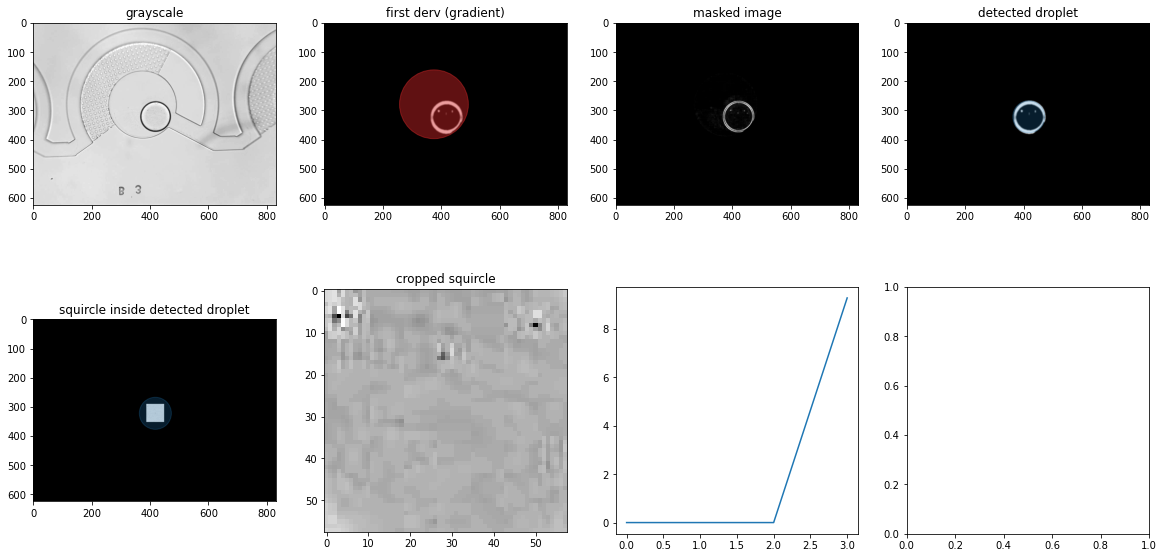

In [5]:
c = 0
w = 2
t = 5


image = time_resolution[t][c][w]['gray'].copy()
img  = time_resolution[t][c][w]['img'].copy() # masked img
grad  = time_resolution[t][c][w]['grad2'].copy()
xd = time_resolution[t][c][w]['droplet data'][0,0]
yd = time_resolution[t][c][w]['droplet data'][0,1]
rd = time_resolution[t][c][w]['droplet data'][0,2]
xw = time_resolution[t][c][w]['x']
yw = time_resolution[t][c][w]['y']
rw = time_resolution[t][c][w]['r']

print("meanlist", time_resolution[0][c][w]['mean list'], "; mean:", np.mean(time_resolution[0][c][w]['mean list']))
print("Areas:", time_resolution[0][c][w]['areas'])
print("starting conc:", starting_concentrations[c])
print("LLPS conc:", time_resolution[0][c][w]['LLPS conc'])

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

axs[0, 0].imshow(image, cmap="gray")
axs[0,0 ].set_title("grayscale")

axs[0, 1].imshow(grad, cmap="gray")
axs[0, 1].set_title("first derv (gradient)")
circle = plt.Circle((xw, yw), rw, color='tab:red', alpha=0.45)
axs[0, 1].add_patch(circle)

axs[0, 2].imshow(img, cmap="gray")
axs[0, 2].set_title("masked image")

axs[0, 3].imshow(time_resolution[t][c][w]['grad2'], cmap="gray")
axs[0, 3].set_title("detected droplet")
circle = plt.Circle((xd, yd), rd, color='tab:blue', alpha=0.25)
axs[0, 3].add_patch(circle)

axs[1, 0].imshow(time_resolution[t][c][w]['squ'], cmap="gray")
axs[1, 0].set_title("squircle inside detected droplet")
circle = plt.Circle((xd, yd), rd, color='tab:blue', alpha=0.25)
axs[1, 0].add_patch(circle)

axs[1, 1].imshow(time_resolution[t][c][w]['cro squ'], cmap="gray")
axs[1, 1].set_title("cropped squircle")

axs[1, 2].plot(np.arange(len(time_resolution[0][c][w]['mean list'])), time_resolution[0][c][w]['mean list'])
axs[1, 2].scatter(t, time_resolution[0][c][w]['mean list'][t], color='red')

blurrr = cv2.dilate(time_resolution[t][c][w]['cro squ'], (5,5))
print(blurrr.shape[0]*blurrr.shape[0] - np.count_nonzero(blurrr))

## Plot the data

In [ ]:
### figure setup ###


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8), sharex=False, sharey=False)

# set labels
ax1.set_xlabel(f"{name_sol2} [{unit_sol2}]")
ax1.set_ylabel(f"{name_sol1} [{unit_sol1}]")
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.set_xlabel(ax1.get_xlabel())
ax2.xaxis.label.set_size(ax1.xaxis.label.get_size())
ax2.set_ylabel(ax1.get_ylabel())
ax2.yaxis.label.set_size(ax1.yaxis.label.get_size())

# set limits 
xlim = int(initial_conc_sol2 * 6)
ylim = int(initial_conc_sol1 * 6)
ax1.set_xlim(0, xlim)
ax1.set_ylim(0, ylim)
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

# set titles
ax1.set_title('individual wells', fontsize=25)
ax2.set_title('means', fontsize= 25)

# set ticks
ax1.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax1.tick_params(axis='y', which='minor', right=True)
ax1.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax1.tick_params(axis='x', which='minor', bottom=True, top=True)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax1.yaxis.set_minor_locator(AutoMinorLocator(20))
ax1.xaxis.set_tick_params(which='both', width=2)
ax1.yaxis.set_tick_params(which='both', width=2)


ax2.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax2.tick_params(axis='y', which='minor', right=True)
ax2.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax2.tick_params(axis='x', which='minor', bottom=True, top=True)
ax2.minorticks_on()
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_minor_locator(AutoMinorLocator(20))
ax2.xaxis.set_tick_params(which='both', width=2)
ax2.yaxis.set_tick_params(which='both', width=2)


# plot starting concentrations and the data
well_nr = 0

for conc_nr in range (number_of_diff_conc):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['areas'][0, 1] != 0:
            
                if conc_nr == 0:
                    color = "blue"
                if conc_nr == 1:
                    color = "orange"
                if conc_nr == 2:
                    color = "gray"
                if conc_nr == 3:
                    color = "yellow"
                if conc_nr == 4:
                    color = "green"

                ax1.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")
                ax1.scatter(time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1],time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0],
                            s=60, color=color, marker="o", edgecolors="black")
                
            well_nr += 1
        well_nr = 0
well_nr = 0


# calculate and plot mean
mean_sol1 = []
mean_sol1 = [0] * 5
mean_sol2 = []
mean_sol2 = [0] * 5
n_llps_wells = []
n_llps_wells = [0] * 5

for conc_nr in range (number_of_diff_conc):
        for n_wells_per_horizontal in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['areas'][0, 1] != 0:           
                # calculate mean
                mean_sol1[conc_nr] = mean_sol1[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0]
                print(conc_nr, well_nr, time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0])
                mean_sol2[conc_nr] = mean_sol2[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1]
                n_llps_wells[conc_nr] += 1
                
            well_nr += 1
        well_nr = 0
well_nr = 0

print("post post", mean_sol1[1])

for conc_nr in range(number_of_diff_conc):
    if conc_nr == 0:
        color = "blue"
    if conc_nr == 1:
        color = "orange"
    if conc_nr == 2:
        color = "gray"
    if conc_nr == 3:
        color = "yellow"
    if conc_nr == 4:
        color = "green"
    if n_llps_wells[conc_nr] > 0:
        mean_sol1[conc_nr] = mean_sol1[conc_nr]/n_llps_wells[conc_nr]
        mean_sol2[conc_nr] = mean_sol2[conc_nr]/n_llps_wells[conc_nr]
        m = mean_sol1[conc_nr]/mean_sol2[conc_nr]
        
    ax2.plot([0, mean_sol2[conc_nr],xlim], [0, mean_sol1[conc_nr], m*xlim], color=color, linestyle='dashed', alpha=0.50)
    ax2.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")

    ax2.scatter(mean_sol2[conc_nr],mean_sol1[conc_nr], s=60, color=color,
                           marker="o", edgecolors="black")
 